# Week 3: Day 3 AM // Clustering

## Toy Dataset Analysis

In [24]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

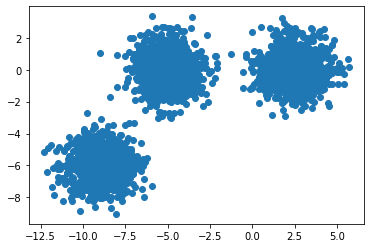

In [35]:
mean1 = (-5, 0)
cov = [[1, 0], [0, 1]]
data_1 = np.random.multivariate_normal(mean1, cov, (1000))

mean2 = (-9, -6)
data_2 = np.random.multivariate_normal(mean2, cov, (1000))

mean3 = (2.5, 0)
data_3 = np.random.multivariate_normal(mean3, cov, (1000))

X=np.vstack([data_1,data_2,data_3])
y = np.hstack([[1]*1000,[2]*1000,[3]*1000])
plt.scatter(X[:,0],X[:,1])

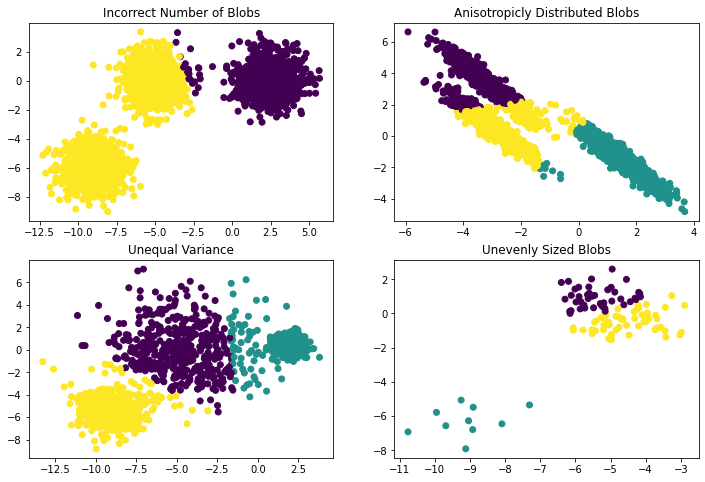

In [36]:
plt.figure(figsize=(12, 8))

#n_samples = 1500
#random_state = 170
#X, y = make_blobs(n_samples=n_samples, random_state=random_state, centers=3)

# Incorrect number of clusters
y_pred = KMeans(n_clusters=2, random_state=random_state).fit_predict(X)

plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Incorrect Number of Blobs")

# Anisotropicly distributed data
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_aniso)

plt.subplot(222)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred)
plt.title("Anisotropicly Distributed Blobs")

# Different variance
X_varied, y_varied = make_blobs(n_samples=n_samples,
                                cluster_std=[1.0, 2.5, 0.5],
                                random_state=random_state)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_varied)

plt.subplot(223)
plt.scatter(X_varied[:, 0], X_varied[:, 1], c=y_pred)
plt.title("Unequal Variance")

# Unevenly sized blobs
X_filtered = np.vstack((X[y == 0][:500], X[y == 1][:100], X[y == 2][:10]))
y_pred = KMeans(n_clusters=3,
                random_state=random_state).fit_predict(X_filtered)

plt.subplot(224)
plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_pred)
plt.title("Unevenly Sized Blobs")

plt.show()

In [26]:
import sklearn

In [27]:
!pip install --upgrade sklearn

Requirement already up-to-date: sklearn in /usr/local/lib/python3.7/dist-packages (0.0)


Generate Data

In [73]:
mean1 = (-5, 0)
cov = [[1, 0], [0, 1]]
data_1 = np.random.multivariate_normal(mean1, cov, (1000))

mean2 = (-9, -6)
data_2 = np.random.multivariate_normal(mean2, cov, (1000))

mean3 = (2.5, 0)
data_3 = np.random.multivariate_normal(mean3, cov, (1000))

X=np.vstack([data_1,data_2,data_3])
y = np.hstack([[1]*1000,[2]*1000,[3]*1000])

r=2
x1_r1 = 2.5+r*np.cos(theta)
x2_r1 = r*np.sin(theta)
X_r1 = np.vstack([x1_r1,x2_r1]).T

x1_r2 = -9+r*np.cos(theta)
x2_r2 = -6+r*np.sin(theta)
X_r2 = np.vstack([x1_r2,x2_r2]).T

x1_r3 = -5+r*np.cos(theta)
x2_r3 = r*np.sin(theta)
X_r3 = np.vstack([x1_r3,x2_r3]).T

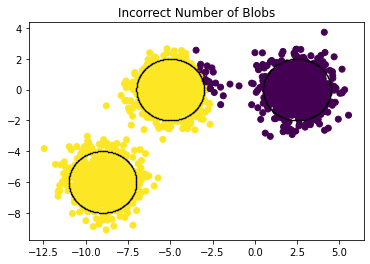

In [76]:
y_pred = KMeans(n_clusters=2, random_state=random_state).fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Incorrect Number of Blobs")

plt.scatter(x1_r1,x2_r1,s=0.1,c='black')
plt.scatter(x1_r2,x2_r2,s=0.1,c='black')
plt.scatter(x1_r3,x2_r3,s=0.1,c='black')

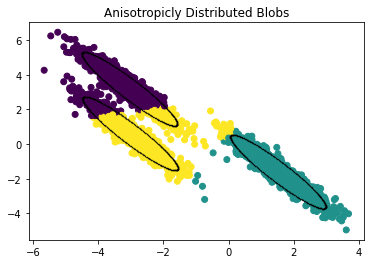

In [71]:
# Anisotropicly distributed data
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_aniso)

plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred)
plt.title("Anisotropicly Distributed Blobs")

# Anisotropicly distributed data
X_r1_aniso = np.dot(X_r1, transformation)
plt.scatter(X_r1_aniso[:, 0], X_r1_aniso[:, 1],s=0.1,c='black')

# Anisotropicly distributed data
X_r2_aniso = np.dot(X_r2, transformation)
plt.scatter(X_r2_aniso[:, 0], X_r2_aniso[:, 1],s=0.1,c='black')

# Anisotropicly distributed data
X_r3_aniso = np.dot(X_r3, transformation)
plt.scatter(X_r3_aniso[:, 0], X_r3_aniso[:, 1],s=0.1,c='black')


In [91]:
mean1 = (-5, 0)
cov = [[2.5**2, 0], [0, 2.5**2]]
data_1 = np.random.multivariate_normal(mean1, cov, (1000))

mean2 = (-9, -6)
cov = [[1, 0], [0, 1]]
data_2 = np.random.multivariate_normal(mean2, cov, (1000))

mean3 = (2.5, 0)
cov = [[0.5**2, 0], [0, 0.5**2]]
data_3 = np.random.multivariate_normal(mean3, cov, (1000))

X=np.vstack([data_1,data_2,data_3])
y = np.hstack([[1]*1000,[2]*1000,[3]*1000])

r=1
x1_r1 = 2.5+r*np.cos(theta)
x2_r1 = r*np.sin(theta)
X_r1 = np.vstack([x1_r1,x2_r1]).T

r=2
x1_r2 = -9+r*np.cos(theta)
x2_r2 = -6+r*np.sin(theta)
X_r2 = np.vstack([x1_r2,x2_r2]).T

r=4
x1_r3 = -5+r*np.cos(theta)
x2_r3 = r*np.sin(theta)
X_r3 = np.vstack([x1_r3,x2_r3]).T

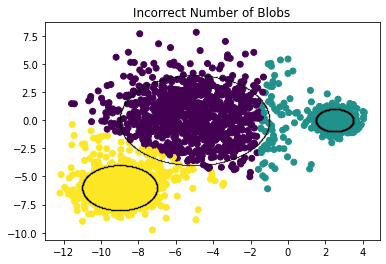

In [92]:
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Incorrect Number of Blobs")

plt.scatter(x1_r1,x2_r1,s=0.1,c='black')
plt.scatter(x1_r2,x2_r2,s=0.1,c='black')
plt.scatter(x1_r3,x2_r3,s=0.1,c='black')

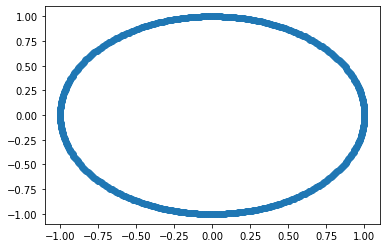